# Computing PET

In [1]:
import calendar
from pathlib import Path

import pandas as pd
import rioxarray as rxr

import hydrosignatures as hsg
import pydaymet as daymet
from pynhd import WaterData
from pygeohydro import NWIS

In [2]:
import warnings

warnings.filterwarnings("ignore", message=".*Index.*")

`PyDaymet` offers three methods for computing PET: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's validate its PET estimation methods with long-term mean monthly PET measurement from [TexasET Network](https://texaset.tamu.edu) for Houston, TX.

We choose station ID of 08071000 and time period of 2000-2009.

In [3]:
station = "08071000"
dates = ("2000-01-01", "2009-01-12")
root = Path("input_data")

In [4]:
clm_par = Path(root, f"{station}_clm_single_pixel.parquet")
clm_nc = Path(root, f"{station}_clm_basin.nc")

site = NWIS().get_info({"site": station})
coords = site[["dec_long_va", "dec_lat_va"]].iloc[0].to_list()

if clm_par.exists() and clm_nc.exists():
    clm_c = pd.read_parquet(clm_par)
    clm_b = rxr.open_rasterio(clm_nc)
else:
    clm_c = daymet.get_bycoords(tuple(coords), dates)
    clm_c.to_parquet(clm_par)

    wd = WaterData("gagesii_basins")
    basin = wd.byid("gage_id", station)
    clm_b = daymet.get_bygeom(basin.geometry[0], dates)
    clm_b.to_netcdf(clm_nc)

Next, we get the long-term mean monthly PET records for Houston, TX, from TexasET Network.

In [5]:
eto_obs = pd.Series(
    [2.36, 2.83, 4.32, 5.01, 6.11, 6.57, 6.52, 6.08, 5.57, 4.28, 2.90, 2.35],
    index=range(1, 13),
)
eto_obs.index.name = "month"
month_abbr = dict(enumerate(calendar.month_abbr))
eto_obs.index = eto_obs.index.map(month_abbr)
# convert to mm/month from in./month
eto_obs = eto_obs * 25.4

Now, let's compute PET using three methods by PyDaymet.

In [6]:
single, gridded, style = {}, {}, {}
methods = {"HS": "hargreaves_samani", "PM": "penman_monteith", "PT": "priestley_taylor"}
for n, m in methods.items():
    pet_c = daymet.potential_et(clm_c, coords, method=m)
    single[f"{n} (Single Pixel)"] = pet_c["pet (mm/day)"]
    style[f"{n} (Single Pixel)"] = "-"
    pet_b = daymet.potential_et(clm_b, method=m)
    gridded[f"{n} (Areal Average)"] = pet_b.pet.mean(dim=["x", "y"]).values.flatten()
    style[f"{n} (Areal Average)"] = "--"
style["TexasET"] = "-"

Finally, let's compute mean monthly PET for each method and compare with the long-term mean monthly PET records. For computing mean monthly PET from daily we use HyRiver's [HydroSignatures](https://docs.hyriver.io/readme/hydrosignatures.html) package.

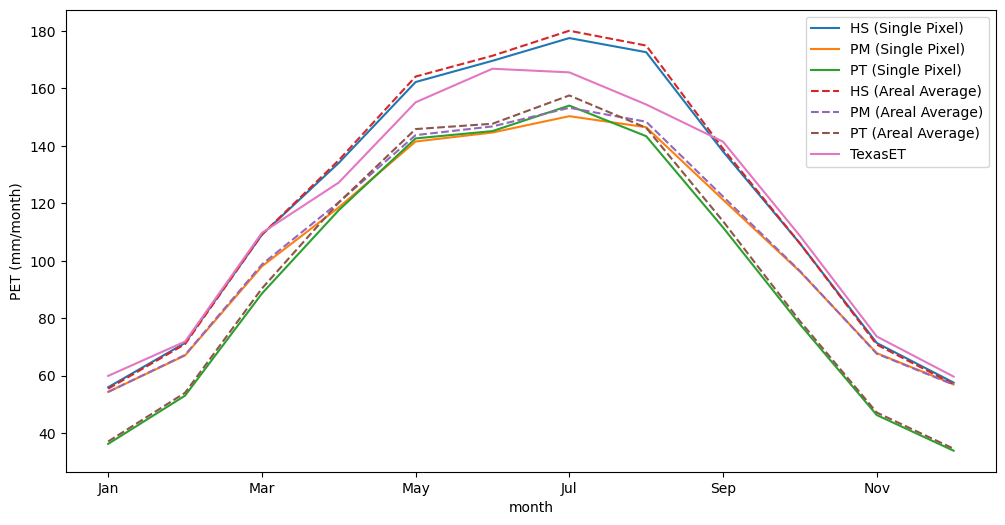

In [7]:
mean_month = hsg.compute_mean_monthly(pd.DataFrame({**single, **gridded}), index_abbr=True)
mean_month["TexasET"] = eto_obs
ax = mean_month.plot(figsize=(12, 6), ylabel="PET (mm/month)", style=style)
ax.figure.savefig(
    Path("_static", "pet_validation.png"), dpi=300, bbox_inches="tight", facecolor="w"
)